<a href="https://colab.research.google.com/github/Vaishnavi1199/Biomedical-image-segmentation-and-classification/blob/master/Final_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd/content/drive/My Drive

/content/drive/My Drive


Libraries

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from pathlib import Path

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split,StratifiedKFold

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Add,MaxPool2D,UpSampling2D,Concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.initializers import RandomNormal

import sys
sys.path.insert(0, '/content/drive/My Drive/Keras-Group-Normalization-master')
from group_norm import GroupNormalization

Data preparation

In [4]:
X=[]
y=[]
width=256
height=256
for i in os.scandir("/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/train/image"):
  a=(str(Path(i)).split('/')[9]).split(".")[0]
  img_arr=cv2.imread(f"/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/train/image/{a}.png", cv2.IMREAD_GRAYSCALE)
  img_arr = cv2.resize(img_arr, (width, height))
  new_arr = img_arr/255.0
  X.append(new_arr)

  truth_img_arr=cv2.imread(f"/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/train/mask/{a}.png", cv2.IMREAD_GRAYSCALE)
  truth_new_arr = cv2.resize(truth_img_arr, (height, width))
  truth_new_arr = truth_new_arr/255.0
  y.append(truth_new_arr)

print(len(X))
print(len(y))

1240
1240


In [5]:
X = np.array(X).reshape(-1, width, height, 1)
y = np.array(y).reshape(-1, width, height, 1)

print(X.shape)
print(y.shape)

(1240, 256, 256, 1)
(1240, 256, 256, 1)


In [6]:
np.save("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/b_train.npy",X)
np.save("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/m_train.npy",y)

In [8]:
X=[]
y=[]
width=256
height=256
for i in os.scandir("/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/test/image"):
  a=(str(Path(i)).split('/')[9]).split(".")[0]
  img_arr=cv2.imread(f"/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/test/image/{a}.png", cv2.IMREAD_GRAYSCALE)
  img_arr = cv2.resize(img_arr, (width, height))
  new_arr = img_arr/255.0
  X.append(new_arr)

  truth_img_arr=cv2.imread(f"/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/test/mask/{a}.png", cv2.IMREAD_GRAYSCALE)
  truth_new_arr = cv2.resize(truth_img_arr, (height, width))
  truth_new_arr = truth_new_arr/255.0
  y.append(truth_new_arr)

print(len(X))
print(len(y))

64
64


In [10]:
X_test = np.array(X).reshape(-1, width, height, 1)
y_test = np.array(y).reshape(-1, width, height, 1)

print(X_test.shape)
print(y_test.shape)

(64, 256, 256, 1)
(64, 256, 256, 1)


In [11]:
np.save("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/b_test.npy",X_test)
np.save("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/m_test.npy",y_test)

Data Loading

In [4]:
X_train= np.load("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/b_train.npy")
y_train= np.load("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/m_train.npy")
X_test= np.load("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/b_test.npy")
y_test= np.load("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/m_test.npy")

X_train.shape , y_train.shape , X_test.shape , y_test.shape

((1240, 256, 256, 1),
 (1240, 256, 256, 1),
 (64, 256, 256, 1),
 (64, 256, 256, 1))

Model - U-NET with RESIDUAL NETWORK and GROUP NORMALIZATION

In [5]:
def encoder(layer_in,filters):
  
  e= Conv2D(filters,kernel_size=3,strides=1,padding='same',kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(layer_in)
  #e= BatchNormalization(momentum=0.5)(e)
  e= GroupNormalization(groups=8)(e)
  e= Activation('relu')(e)

  e= Conv2D(filters,kernel_size=3,strides=1,padding='same',kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(e)
  #e= BatchNormalization(momentum=0.5)(e)
  e= GroupNormalization(groups=8)(e)
  e= Activation('relu')(e)

  f=Conv2D(filters,kernel_size=1,strides=1,kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(layer_in)

  add= Add()([e,f])

  out=Activation('relu')(add)

  maxpool=MaxPool2D(pool_size=(2,2))(out)
  
  return out,maxpool

In [6]:
def upscale(layer_in,filters):
  
  d= UpSampling2D(size=(2,2))(layer_in)
  d=Conv2D(filters,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu',kernel_regularizer='l2')(d)
  
  return d

In [7]:
def concat(layer_e,layer_d):

  c=Concatenate()([layer_e,layer_d])

  return c

In [15]:
def decoder(layer_in,filters,dropout=True):
  
  e= Conv2D(filters,kernel_size=3,strides=1,padding='same',kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(layer_in)
  #e= BatchNormalization(momentum=0.5)(e)
  e= GroupNormalization(groups=8)(e)
  if dropout:
    e=Dropout(0.7)(e)
  e= Activation('relu')(e)

  e= Conv2D(filters,kernel_size=3,strides=1,padding='same',kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(e)
  #e= BatchNormalization(momentum=0.5)(e)
  e= GroupNormalization(groups=8)(e)
  if dropout:
    e=Dropout(0.7)(e)
  e= Activation('relu')(e)

  f=Conv2D(filters,kernel_size=1,strides=1,kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer='l2')(layer_in)

  add= Add()([e,f])

  out=Activation('relu')(add)
  
  return out

In [16]:
def r_unet(image_shape):

  #init = RandomNormal(stddev=0.02)
  input= Input(shape=image_shape)

  e1 , e1_maxpool = encoder(input,16)
  e2 , e2_maxpool = encoder(e1_maxpool , 32)
  e3 , e3_maxpool = encoder(e2_maxpool , 64)
  e4 , e4_maxpool = encoder(e3_maxpool , 128)
  e5 , e5_maxpool = encoder(e4_maxpool , 256)
  e6 , _ = encoder(e5_maxpool , 512)
  #e7 , _          = encoder(e6_maxpool , 512)       

  #u6 = upscale(e7,256)
  #c6 = concat(e6,u6)
  #d6 = decoder(c6,256)

  u5 = upscale(e6,256)
  c5 = concat(e5,u5)
  d5 = decoder(c5,256)

  u4 = upscale(d5,128)
  c4 = concat(e4,u4)
  d4 = decoder(c4,128)

  u3 = upscale(d4,64)
  c3 = concat(e3,u3)
  d3 = decoder(c3,64)

  u2 = upscale(d3,32)
  c2 = concat(e2,u2)
  d2 = decoder(c2,32, dropout=False)

  u1 = upscale(d2,16)
  c1 = concat(e1,u1)
  d1 = decoder(c1,16, dropout=False)

  output=Conv2D(filters=1,kernel_size=(4,4),activation='sigmoid',padding='same',data_format="channels_last")(d1)
  out_image = Activation('tanh')(output)
  model = Model(input, out_image)
  model.summary()
  return model

In [17]:
model=r_unet((256,256,1))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
group_normalization_22 (GroupNo (None, 256, 256, 16) 32          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 256, 256, 16) 0           group_normalization_22[0][0]     
_______________________________________________________________________________________

CUSTOM METRICS AND LOSS FUNCTION

In [18]:
smooth=1
#1) dice_loss
def dice_loss(y_true,y_pred):
  intersection= tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
  a = tf.keras.backend.sum(tf.keras.backend.square(y_true),axis=-1)
  b = tf.keras.backend.sum(tf.keras.backend.square(y_pred),axis=-1)
  return 1- (2*intersection+smooth)/(a+b+smooth)

#2) dice_coef
def dice_coef(y_true,y_pred):
  intersection= tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
  a = tf.keras.backend.sum(tf.keras.backend.square(y_true),axis=-1)
  b = tf.keras.backend.sum(tf.keras.backend.square(y_pred),axis=-1)
  return (2*intersection+smooth)/(a+b+smooth)

# 3) jaccard
def jaccard_distance(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
  sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
  jac = (intersection) / (sum_ - intersection)
  return tf.reduce_mean(jac)

COMPILE

In [19]:
opt1=Adam(learning_rate=0.0001 , beta_1=0.5)
model.compile(optimizer=opt1, loss=dice_loss, metrics=['accuracy', jaccard_distance , dice_coef])

CALLBACKS

In [20]:
#callbacks
callbacks = [EarlyStopping(patience=10, verbose=1,monitor='val_loss'),
             ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
             ModelCheckpoint('/content/drive/Shared drives/Ridhi and Vaishnavi/Final/segmentation-checkpoints/s-19.h5', verbose=1, save_best_only=True )]

TRAIN

In [21]:
#fit
results = model.fit(X_train, y_train , batch_size=16, epochs=200, verbose=1, callbacks=callbacks, validation_split=0.1 )

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 28.5581 - accuracy: 0.9393 - jaccard_distance: 0.0390 - dice_coef: 0.9544
Epoch 00001: val_loss improved from inf to 21.80724, saving model to /content/drive/Shared drives/Ridhi and Vaishnavi/Final/segmentation-checkpoints/s-19.h5
70/70 [==============================] - 32s 452ms/step - loss: 28.5581 - accuracy: 0.9393 - jaccard_distance: 0.0390 - dice_coef: 0.9544 - val_loss: 21.8072 - val_accuracy: 0.9602 - val_jaccard_distance: 0.0298 - val_dice_coef: 0.9791
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 17.2698 - accuracy: 0.9436 - jaccard_distance: 0.0718 - dice_coef: 0.9773
Epoch 00002: val_loss improved from 21.80724 to 13.30725, saving model to /content/drive/Shared drives/Ridhi and Vaishnavi/Final/segmentation-checkpoints/s-19.h5
70/70 [==============================] - 30s 432ms/step - loss: 17.2698 - accuracy: 0.9436 - jaccard_distance: 0.0718 - dice_coef: 0.9773 - val_loss: 13.3072 -

EVALUATION

In [22]:
TP , Union , FP , FN = list() , list() , list() ,list()

In [24]:
for i in range(64):
  x= X_test[i].reshape(-1,256,256,1)
  y= y_test[i].reshape(-1,256,256,1)
  #print(y_test.shape)
  pred = model.predict(x,batch_size=1)
  pred_t = (pred > 0.5).astype(np.uint8)
  #img= pred_t.reshape(256,256,1)
  #img= array_to_img(img)
  #cv2.imwrite("")
  tp = np.sum(np.logical_and(y,pred_t))
  fp = np.sum(np.logical_and((np.logical_not(y)),pred_t))
  fn = np.sum(np.logical_and(y,(np.logical_not(pred_t))))
  union = np.sum(np.logical_or(y, pred_t))
  TP.append(tp)
  FP.append(fp)
  FN.append(fn)
  Union.append(union)

In [26]:
Tp = np.mean(TP)
Fp = np.mean(FP)
Fn = np.mean(FN)
Tn = 256*256 - (Tp+Fp+Fn)

dice_coef = 2*Tp/(Tp+Fn+Tp+Fn)
dice_loss=1-2*Tp/(Tp+Fn+Tp+Fn)
accuracy=(Tp+Tn)/(Tp+Tn+Fp+Fn)
precision=Tp/(Tp+Fp)
recall=Tp/(Tp+Fn)
sensitivity=recall
F1= (2*precision*recall)/(precision+recall)
Jaccard = Tp/(Tp+Fp+Fn)
specificity=Tn/(Fp+Tn)

In [27]:
print(f'dice_coef = {dice_coef}')
print(f'jaccard_index = {Jaccard}')
print(f'F1_score = {F1}')

dice_coef = 0.6786825216520243
jaccard_index = 0.6241118809611961
F1_score = 0.7685577431917173


In [45]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f'sensitivity = {sensitivity}')
print(f'specificity = {specificity}')
print(f'dice_loss = {dice_loss}')
print(f'accuracy = {accuracy}')

precision = 0.8858699732238933
recall = 0.6786825216520243
sensitivity = 0.6786825216520243
specificity = 0.995422844329789
dice_loss = 0.32131747834797575
accuracy = 0.9796669483184814


TESTING

In [32]:
# saving all the generated masks out of test images in a separate folder
for i in range(64):
  x1= X_test[i].reshape(-1,256,256,1)
  y1= y_test[i].reshape(-1,256,256,1)
  pred1 = model.predict(x1,batch_size=1)
  pred_t1 = (pred1 > 0.5).astype(np.uint8)
  img= pred_t1.reshape(256,256,1)
  img= array_to_img(img)
  img.save(f"/content/drive/Shared drives/Ridhi and Vaishnavi/dataset_new1/segmentation_normal/test/pred-1/{i}.png")


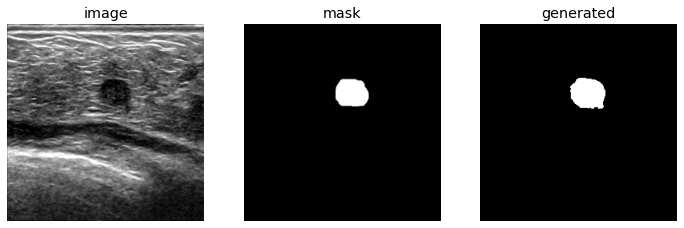

In [43]:
# displaying breast ultrasound image, ground truth and generated mask
fig=plt.figure(figsize=(12,16))
A= X_test[0].reshape(256,256,1)
A= array_to_img(A)
plt.subplot(1,3,1)
plt.axis("off")
plt.title("image")
plt.imshow(A,cmap="gray")

B= y_test[0].reshape(256,256,1)
B= array_to_img(B)
plt.subplot(1,3,2)
plt.axis("off")
plt.title("mask")
plt.imshow(B,cmap="gray")

pred1 = model.predict(X_test[0].reshape(-1,256,256,1),batch_size=1)
pred_t1 = (pred1 > 0.5).astype(np.uint8)


C= pred_t1.reshape(256,256,1)
C= array_to_img(C)
plt.subplot(1,3,3)
plt.axis("off")
plt.title("generated")
plt.imshow(C,cmap="gray")


In [41]:
# checking if the model is loading and working
m = load_model("/content/drive/Shared drives/Ridhi and Vaishnavi/Final/segmentation-checkpoints/s-19.h5", custom_objects={'dice_loss': dice_loss , 'jaccard_distance':jaccard_distance ,'dice_coef':dice_coef} )

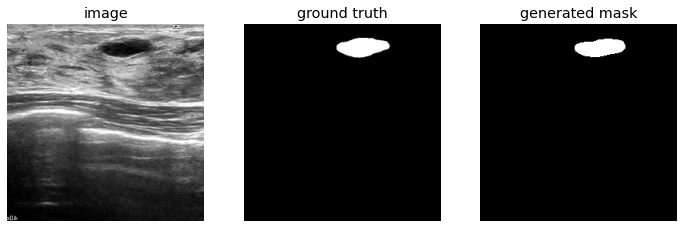

In [44]:
fig=plt.figure(figsize=(12,16))
A= X_test[5].reshape(256,256,1)
A= array_to_img(A)
plt.subplot(1,3,1)
plt.axis("off")
plt.title("image")
plt.imshow(A,cmap="gray")

B= y_test[5].reshape(256,256,1)
B= array_to_img(B)
plt.subplot(1,3,2)
plt.axis("off")
plt.title("ground truth")
plt.imshow(B,cmap="gray")

pred1 = m.predict(X_test[5].reshape(-1,256,256,1),batch_size=1)
pred_t1 = (pred1 > 0.5).astype(np.uint8)


C= pred_t1.reshape(256,256,1)
C= array_to_img(C)
plt.subplot(1,3,3)
plt.axis("off")
plt.title("generated mask")
plt.imshow(C,cmap="gray")